In [10]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import backend as K

from MD_AE_model import *

import h5py
import numpy as np
import matplotlib.pyplot as plt

In [11]:
## import data
folder = '/home/ym917/OneDrive/PhD/Code_md-ae/Hierarchical_2_1__2022_03_29__10_14_44/'
filename = folder + 'results.h5'
hf = h5py.File(filename,'r')
u_test = np.array(hf.get('u_test'))
hist_train = np.array(hf.get('hist_train'))
u_avg = np.array(hf.get('u_avg'))
hf.close()

In [12]:
## load model
filename = folder + 'subnet1'
subnet1 = tf.keras.models.load_model(filename)
filename = folder + 'subnet2'
subnet2 = tf.keras.models.load_model(filename)

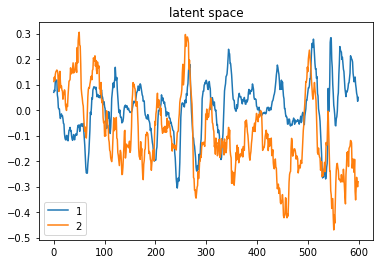

In [13]:
## latent space
z1 = subnet1.encoder.predict(u_test)
z2 = subnet2.encoder.predict(u_test)
plt.figure()
plt.plot(z1,label='1')
plt.plot(z2,label='2')
plt.legend()
plt.title('latent space')
plt.show()

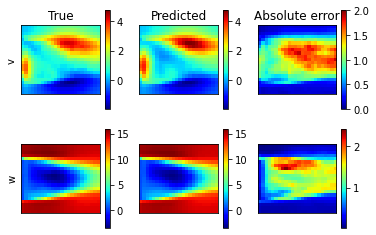

In [17]:
# autoencoder results
y_test = subnet1.predict([u_test])
# y_test = subnet2.predict([u_test,z1])
u_mean = u_test + u_avg
y_mean = y_test + u_avg
y_mean = np.mean(y_mean,0)
u_mean = np.mean(u_mean,0)
e = np.abs(y_test-u_test)
e_mean = np.mean(e,0)

umin = min(np.amin(u_mean[:,:,0]),np.amin(y_mean[:,:,0]))
umax = max(np.amax(u_mean[:,:,0]),np.amax(y_mean[:,:,0]))

vmin = min(np.amin(u_mean[:,:,1]),np.amin(y_mean[:,:,1]))
vmax = max(np.amax(u_mean[:,:,1]),np.amax(y_mean[:,:,1]))

plt.figure()

ax1 = plt.subplot(2,3,1,title="True",xticks=[],yticks=[],ylabel='v')
ax1 = plt.imshow(u_mean[:,:,0],'jet',vmin=umin,vmax=umax)
plt.colorbar()

ax2 = plt.subplot(2,3,2,title="Predicted",xticks=[],yticks=[])
ax2 = plt.imshow(y_mean[:,:,0],'jet',vmin=umin,vmax=umax)
plt.colorbar()

ax3 = plt.subplot(2,3,3,title="Absolute error",xticks=[],yticks=[]) # u error
ax3 = plt.imshow(e_mean[:,:,0],'jet',vmin=0,vmax=2)
plt.colorbar()

ax4 = plt.subplot(2,3,4,xticks=[],yticks=[],ylabel='w')
ax4 = plt.imshow(u_mean[:,:,1],'jet',vmin=vmin,vmax=vmax)
plt.colorbar()

ax5 = plt.subplot(2,3,5,xticks=[],yticks=[])
ax5 = plt.imshow(y_mean[:,:,1],'jet',vmin=vmin,vmax=vmax)
plt.colorbar()

ax6 = plt.subplot(2,3,6,xticks=[],yticks=[]) 
ax6 = plt.imshow(e_mean[:,:,1],'jet')
plt.colorbar()
plt.show()

In [23]:
## modes
mode1 = subnet1.predict([u_test])
mode2 = subnet2.predict([u_test,z1]) - mode1
print(mode1.shape)

(600, 21, 24, 2)
(21, 24, 2)


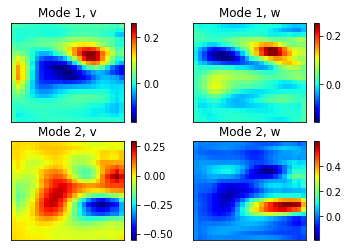

In [31]:
## plt modes
fig,ax = plt.subplots(2,2)

mode1_v = ax[0,0].imshow(np.mean(mode1,axis=0)[:,:,0],'jet')
ax[0,0].set_title('Mode 1, v')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
fig.colorbar(mode1_v,ax=ax[0,0])

mode1_w = ax[0,1].imshow(np.mean(mode1,axis=0)[:,:,1],'jet')
ax[0,1].set_title('Mode 1, w')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
fig.colorbar(mode1_w,ax=ax[0,1])

mode2_v = ax[1,0].imshow(np.mean(mode2,axis=0)[:,:,0],'jet')
ax[1,0].set_title('Mode 2, v')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.colorbar(mode2_v,ax=ax[1,0])

mode2_w = ax[1,1].imshow(np.mean(mode2,axis=0)[:,:,1],'jet')
ax[1,1].set_title('Mode 2, w')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.colorbar(mode2_w,ax=ax[1,1])

plt.show()